In [1]:
import snap
import pandas as pd
import numpy
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
MIN = 60

In [3]:
# Parse tracks file, ignore tracks that has no track id
all_listened = pd.read_csv("dataset\lastfm-dataset-1K\userid-timestamp-artid-artname-traid-traname.tsv", nrows=None, sep='\t', 
                     header=None, names=['user_id', 'timestamp', 'track_id', 'track_name'], 
                     parse_dates=[1], usecols=[0,1,4,5], error_bad_lines=False, warn_bad_lines=True).dropna()

Skipping line 2120260: expected 6 fields, saw 8

Skipping line 2446318: expected 6 fields, saw 8

Skipping line 11141081: expected 6 fields, saw 8

Skipping line 11152099: expected 6 fields, saw 12
Skipping line 11152402: expected 6 fields, saw 8

Skipping line 11882087: expected 6 fields, saw 8

Skipping line 12902539: expected 6 fields, saw 8
Skipping line 12935044: expected 6 fields, saw 8

Skipping line 17589539: expected 6 fields, saw 8



In [4]:
# Extract two weeks data
all_listened_two_weeks = all_listened[(all_listened['timestamp'] >= '2009-04-07 00:00:00') & 
                                      (all_listened['timestamp'] < '2009-05-05 00:00:00')]

In [120]:
# Extract only two days data for all users in the dataset
begin = '2009-04-21 00:00:00'
finish = '2009-05-05 00:00:00'
all_listened = all_listened_two_weeks[(all_listened_two_weeks['timestamp'] >= begin) & 
                                      (all_listened_two_weeks['timestamp'] < finish)]

In [6]:
# Info about data
all_listened.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199174 entries, 10 to 19081161
Data columns (total 4 columns):
user_id       199174 non-null object
timestamp     199174 non-null datetime64[ns]
track_id      199174 non-null object
track_name    199174 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 7.6+ MB


In [7]:
# Helper dataframe where all listened songs are shifted once so that it can be concatenated
# with the original all_listened dataframe. The resulting dataframe holds rows for all consecutively listen tracks
all_listened_helper = all_listened.rename(columns={'user_id': 'user_id_2', 'timestamp': 'timestamp_2', 
                                                   'track_id': 'track_id_2', 'track_name': 'track_name_2'}).shift()
cons_listened = pd.concat([all_listened, all_listened_helper], axis=1)

In [8]:
# Remove rows for which user id is not the same, tracks are identical 
# or the time difference between two consecutive tracks is bigger than the thredhsold MIN 
cons_listened = cons_listened[(cons_listened['user_id'] == cons_listened['user_id_2']) & 
                              (cons_listened['track_id'] != cons_listened['track_id_2']) &
                              ((cons_listened['timestamp_2']-cons_listened['timestamp']).astype('timedelta64[m]') <= MIN)]

In [9]:
cons_listened[(cons_listened['track_id'] == 'f94fb7e7-76a2-4d84-8734-949f08b0e65b') | 
              (cons_listened['track_id'] == '37f12582-e0aa-4f53-bb2e-d1527e8f2299')]

,user_id,timestamp,track_id,track_name,user_id_2,timestamp_2,track_id_2,track_name_2
1926531,user_000094,2009-04-21 19:01:35,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000094,2009-04-21 19:06:19,7f29e3ad-50f1-499d-9811-566e490852cc,Gold Lion
1926534,user_000094,2009-04-21 18:34:19,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000094,2009-04-21 18:38:05,0ea9ada6-fe62-403c-af08-159af46a1a3a,Hush
8123237,user_000431,2009-04-24 16:00:23,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown,user_000431,2009-04-24 16:05:24,e491e999-91fc-43fd-a32c-4493405ec7c5,I Don'T Like The Drugs (But The Drugs Like Me)
8123634,user_000431,2009-04-23 01:35:39,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000431,2009-04-23 01:39:25,79b675dd-f7c4-4bef-a924-0b18cf449535,I'M Gonna Crawl
14255172,user_000761,2009-04-29 20:21:35,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000761,2009-04-29 20:25:19,3e85a4cc-3733-4160-8982-6fa6da51cfbc,Primrose Path
16060176,user_000833,2009-05-04 06:47:31,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000833,2009-05-04 06:47:55,6f71016e-8be0-4f9c-b72a-f88cc8347d3c,"Endlessly, She Said"
16060177,user_000833,2009-05-04 06:43:45,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown,user_000833,2009-05-04 06:47:31,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat
16060178,user_000833,2009-05-04 06:43:45,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000833,2009-05-04 06:43:45,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown
16060179,user_000833,2009-05-04 06:38:43,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown,user_000833,2009-05-04 06:43:45,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat
16060782,user_000833,2009-04-23 03:17:26,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000833,2009-04-23 03:21:13,cc8b98af-0bf4-4591-897e-1f0bde9391f7,"Sell My Old Clothes, I'M Off To Heaven"


In [9]:
def cons_group(track_1_id, track_2_id):
    """ Function to determine the group based on two tracks presented in the row. """
    if track_1_id > track_2_id:
        return track_1_id, track_2_id
    else:
        return track_2_id, track_1_id

# Count how many times each two tracks were played one after other in MIN minutes period 
cons_listened_counts = pd.DataFrame({'cons_count' : cons_listened.groupby(
            numpy.vectorize(cons_group)(cons_listened['track_id'], cons_listened['track_id_2'])
        ).size()}).reset_index()

#cons_listened_counts

In [10]:
# Count how many times each song were played in total
track_counts = all_listened.groupby(['track_id', 'track_name']).size()

In [11]:
# Create a tracks map where each track id -> track name, track total count, integer id
tracks_map = {}
for i, (track_id, track_name) in enumerate(track_counts.keys()):
    tracks_map[track_id] = {'track_name': track_name, 'track_count': track_counts[(track_id, track_name)], 'int_id': i} 
    
#tracks_map

In [12]:
len(tracks_map)

92361

In [13]:
def similarity(cons_count, track_1_count, track_2_count):
    """ Function to calculate the similarity between two songs
        given both tracks total counts in the corpus and the 
        number of times both tracks were played one after other"""
    return cons_count*1.0/numpy.sqrt(tracks_map[track_1_count]['track_count']*tracks_map[track_2_count]['track_count'])

# Add similarity column that determines the similarity between two tracks in the row calculated using similarity function
cons_listened_counts['similarity'] = numpy.vectorize(similarity)(cons_listened_counts['cons_count'], 
                                                                 cons_listened_counts['level_0'], 
                                                                 cons_listened_counts['level_1'])

#cons_listened_counts

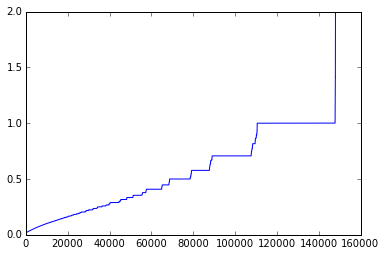

In [14]:
# Plot the similarities between songs in increasing order
plt.plot(cons_listened_counts['similarity'].sort(inplace=False))

In [51]:
# Create song network, add all tracks as nodes in it 
song_network = snap.TUNGraph.New()
labels = {}
for track_id in tracks_map:
    int_id = tracks_map[track_id]['int_id']
    song_network.AddNode(int_id)
    labels[int_id] = track_id

# Only keep the similar tracks and add edges between these tracks in the network specified above
similar_songs = cons_listened_counts[cons_listened_counts['similarity'] > 0.5].values

for similar in similar_songs:
    song_network.AddEdge(tracks_map[similar[0]]['int_id'], tracks_map[similar[1]]['int_id'])
    
print song_network.GetEdges()

69483


In [435]:
import networkx as nx
g = nx.Graph()
for similar in similar_songs:
    g.add_edge(tracks_map[similar[0]]['int_id'], tracks_map[similar[1]]['int_id'])
nx.draw_networkx(g)

In [52]:
# Cluster the tracks network using Clauset-Newman-Moore community detection method
CmtyV = snap.TCnComV()
modularity = snap.CommunityCNM(song_network, CmtyV)
print "The modularity of the network is %f" % modularity

The modularity of the network is 0.999031


In [139]:
# Append cluster ids to all tracks in tracks map
clusters = {}
for i, cluster in enumerate(CmtyV):
    clusters[i] = cluster
    for int_id in cluster:
        track_id = labels[int_id]
        tracks_map[track_id]['cluster_id'] = i

In [60]:
all_listened[all_listened['user_id'] == 'user_000001']

,user_id,timestamp,track_id,track_name
10,user_000001,2009-05-04 13:06:09,f7c1f8f8-b935-45ed-8fc8-7def69d92a10,The Last Emperor (Theme)
12,user_000001,2009-05-04 12:55:34,475d4e50-cebb-4cd0-8cd4-c3df97987962,Tibetan Dance (Version)
14,user_000001,2009-05-03 15:48:25,dc394163-2b78-4b56-94e4-658597a29ef8,"Boy, Boy, Boy (Switch Remix)"
15,user_000001,2009-05-03 15:37:56,340d9a0b-9a43-4098-b116-9f79811bd508,Crocodile (Innervisions Orchestra Mix)
16,user_000001,2009-05-03 15:14:53,0b04407b-f517-4e00-9e6a-494795efc73e,Ninna Nanna In Blu (Raw Deal Remix)
17,user_000001,2009-05-03 15:10:18,4e78efc4-e545-47af-9617-05ff816d86e2,Elysian Fields
18,user_000001,2009-05-03 15:04:31,fb51d2c4-cc69-4128-92f5-77ec38d66859,Planetary Deadlock
19,user_000001,2009-05-03 14:56:25,4277434f-e3c2-41ae-9ce3-23fd157f9347,Good Morning Love Coffee Is Ready
20,user_000001,2009-05-03 14:50:51,1151b040-8022-4965-96d2-8a4605ce456c,Deadly Species
21,user_000001,2009-05-03 14:46:29,f78c95a8-9256-4757-9a9f-213df5c6854e,Cold Fusion


In [64]:
u1 = all_listened[all_listened['user_id'] == 'user_000001'].values

In [65]:
u1

array([['user_000001', Timestamp('2009-05-04 13:06:09'),
        'f7c1f8f8-b935-45ed-8fc8-7def69d92a10', 'The Last Emperor (Theme)'],
       ['user_000001', Timestamp('2009-05-04 12:55:34'),
        '475d4e50-cebb-4cd0-8cd4-c3df97987962', 'Tibetan Dance (Version)'],
       ['user_000001', Timestamp('2009-05-03 15:48:25'),
        'dc394163-2b78-4b56-94e4-658597a29ef8',
        'Boy, Boy, Boy (Switch Remix)'],
       ..., 
       ['user_000001', Timestamp('2009-04-21 14:55:12'),
        'e86a28e6-1afb-40dc-92fe-5f04e9ccc92d', 'Classylassie'],
       ['user_000001', Timestamp('2009-04-21 14:27:03'),
        'f7c1f8f8-b935-45ed-8fc8-7def69d92a10', 'The Last Emperor (Theme)'],
       ['user_000001', Timestamp('2009-04-21 14:16:27'),
        '475d4e50-cebb-4cd0-8cd4-c3df97987962', 'Tibetan Dance (Version)']], dtype=object)

In [80]:
times = []
cluster_ids = []
for _, time, track_id, _ in u1:
    cluster_ids.append(tracks_map[track_id]['cluster_id'])
    times.append(time)

In [135]:
cluster_freq = {}
for c in cluster_ids:
    if c in cluster_freq:
        cluster_freq[c] += 1
    else:
        cluster_freq[c] = 1
        
print cluster_freq

{17539: 2, 14089: 1, 9867: 3, 10562: 3, 11028: 7, 7065: 36, 8484: 17, 4648: 2, 4905: 15, 5804: 57, 4014: 33, 8640: 2, 17090: 14, 7375: 2, 6227: 13, 12504: 2, 2403: 23, 12648: 1, 491: 63, 20465: 4, 9843: 2, 13695: 1}


In [136]:
from datetime import datetime

window_in_mins = (datetime.strptime(finish, "%Y-%m-%d 00:00:00") - datetime.strptime(begin, "%Y-%m-%d 00:00:00")).days * 24.0

In [137]:
for f in cluster_freq:
    cluster_freq[f] = window_in_mins/cluster_freq[f] 

In [138]:
[(c, cluster_freq[c]) for c in sorted(cluster_freq, key=lambda x: cluster_freq[x])]

[(491, 5.333333333333333),
 (5804, 5.894736842105263),
 (7065, 9.333333333333334),
 (4014, 10.181818181818182),
 (2403, 14.608695652173912),
 (8484, 19.764705882352942),
 (4905, 22.4),
 (17090, 24.0),
 (6227, 25.846153846153847),
 (11028, 48.0),
 (20465, 84.0),
 (9867, 112.0),
 (10562, 112.0),
 (17539, 168.0),
 (4648, 168.0),
 (8640, 168.0),
 (7375, 168.0),
 (12504, 168.0),
 (9843, 168.0),
 (14089, 336.0),
 (12648, 336.0),
 (13695, 336.0)]

In [161]:
len(clusters[13695])

1

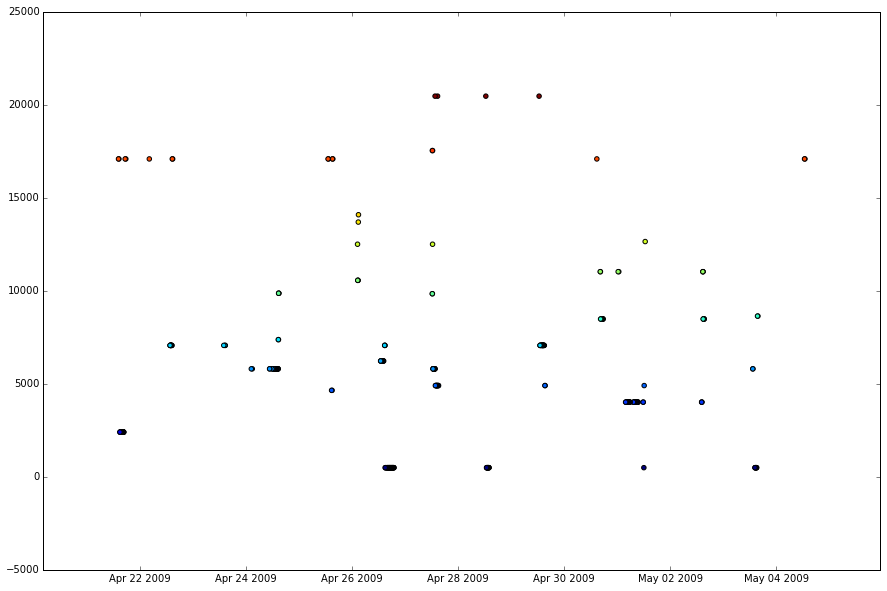

In [117]:
plt.figure(figsize=(15,10), dpi=1000)
axes = plt.gca()
#axes.set_xlim(['2009-05-04 13:06:09','2009-04-21 14:16:27'])
plt.scatter(times, cluster_ids, c=cluster_ids)

In [45]:
print len(CmtyV)
print len([x for x in CmtyV if len(x) > 1])

23237
9860


In [46]:
l = [len(a) for a in CmtyV]

In [47]:
l.sort()
l[-10:]

[245, 248, 280, 287, 291, 300, 304, 342, 344, 355]

In [48]:
s = [a for a in CmtyV if len(a) == 5]

In [49]:
for a in s[0]:
    print labels[a]

Shiola
Loathsome
Splinters Through A Straw
Catching Feathers
Death Salvation
